# Conceptors for Hidden State Visualization


## Set-up

### Import Libraries

In [6]:
from echotorch.datasets import PeriodicSignalDataset
from echotorch.datasets import SinusoidalTimeseries
from echotorch.datasets import DatasetComposer
from echotorch.nn import ConceptorNet, Conceptor
import echotorch.utils
import torch
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

### Hyper-parameter Selection

In [4]:
# Precision
torch.set_printoptions(precision=10)

# Dataset params
washout_period = 500
train_sample_length = 1000
test_sample_length = 1000
n_train_samples = 1
n_test_samples = 1
batch_size = 1

# Params
reservoir_size = 100
spectral_radius = 1.5
input_scaling = 1.5
bias_scaling = 0.2
input_sparsity = 1.0
leak_rate = 1.0
w_sparsity = 0.1
win_mean = 0.0
win_std = 1.0
w_mean = 0.0
w_std = 1.0
wbias_mean = 0.0
wbias_std = 1.0
ridge_param = 0.01
w_ridge_param = 0.0001
aperture = 1
factor = 10.0

### Pattern Initialization

(double check period / m parameters)

In [ ]:
# First pattern
pattern1_training = SinusoidalTimeseries(
    sample_len=washout_period + train_sample_length,
    n_samples=n_train_samples,
    a=1,
    period=0.711572515,
    m=11
)

# Second pattern
pattern2_training = SinusoidalTimeseries(
    sample_len=washout_period + train_sample_length,
    n_samples=n_train_samples,
    a=1,
    period=0.63918467,
    m=0
)

In [8]:
# Third pattern
pattern3_training = PeriodicSignalDataset(
    sample_len=washout_period + train_sample_length,
    n_samples=n_train_samples,
    period=[-1.0, -1.0, -0.1, 0.2, 1.0]
)

# Fourth pattern
pattern4_training = PeriodicSignalDataset(
    sample_len=washout_period + train_sample_length,
    n_samples=n_train_samples,
    period=[-1.0, -0.8, -0.1, 0.2, 1.0]
)

### Compose the Dataset

In [9]:
# Composer
dataset_training = DatasetComposer([pattern1_training, pattern2_training, pattern3_training, pattern4_training])

# Data loader
patterns_loader = DataLoader(dataset_training, batch_size=batch_size, shuffle=False, num_workers=1)

# Network Initialization

In [10]:
esn = ConceptorNet(
    input_dim=1,
    hidden_dim=int(reservoir_size),
    output_dim=1,
    spectral_radius=spectral_radius,
    sparsity=input_sparsity,
    input_scaling=input_scaling,
    w_sparsity=w_sparsity,
    leaky_rate=leak_rate,
    bias_scaling=bias_scaling,
    win_distrib='normal',
    win_normal=(win_mean, win_std),
    w_distrib='normal',
    w_normal=(w_mean, w_std),
    wbias_distrib='normal',
    wbias_normal=(wbias_mean, wbias_std),
    washout=washout_period,
    ridge_param=ridge_param,
    w_ridge_param=w_ridge_param,
    seed=1,
    dtype=torch.float64
)

## Conceptor Initialization

In [11]:
# The four conceptors
pattern1_conceptor = Conceptor(reservoir_size, aperture=aperture, name="pattern1", dtype=torch.float64)
pattern2_conceptor = Conceptor(reservoir_size, aperture=aperture, name="pattern2", dtype=torch.float64)
pattern3_conceptor = Conceptor(reservoir_size, aperture=aperture, name="pattern3", dtype=torch.float64)
pattern4_conceptor = Conceptor(reservoir_size, aperture=aperture, name="pattern4", dtype=torch.float64)
pattern_conceptors = [pattern1_conceptor, pattern2_conceptor, pattern3_conceptor, pattern4_conceptor]

### State Initialization

In [12]:
# Total states
total_states = torch.FloatTensor()

# List of SVD
svd_matrices = list()

# List of patterns
patterns = list()

## Training Loop

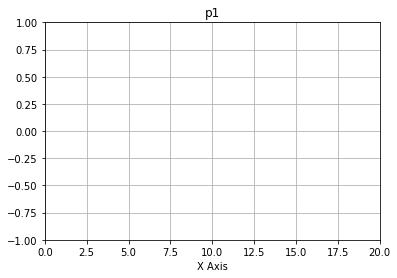

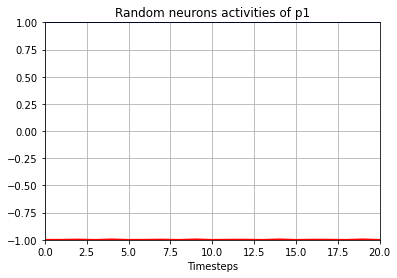

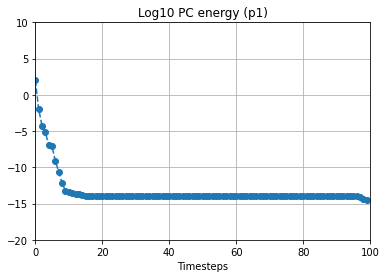

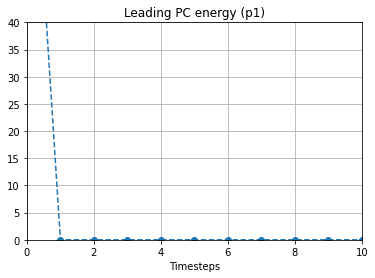

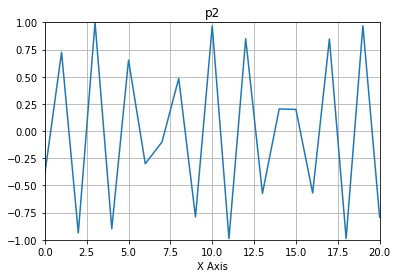

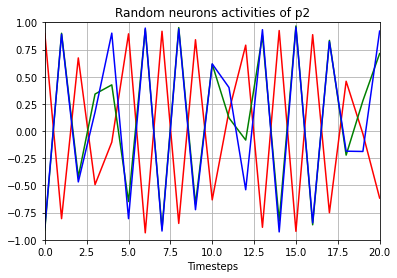

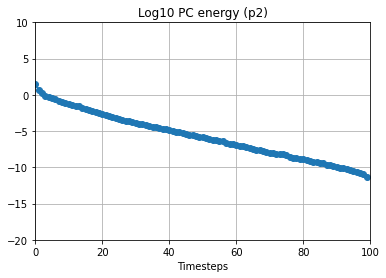

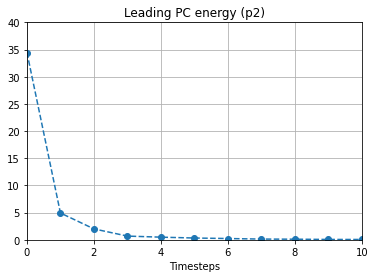

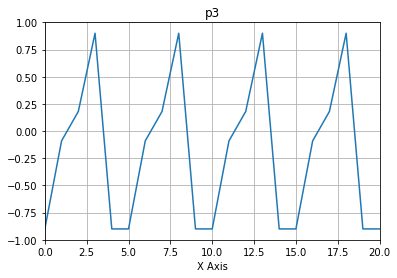

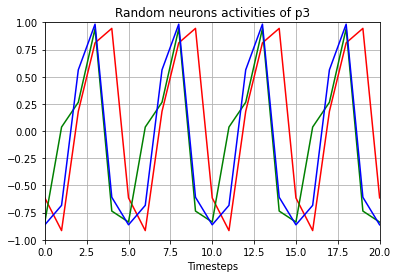

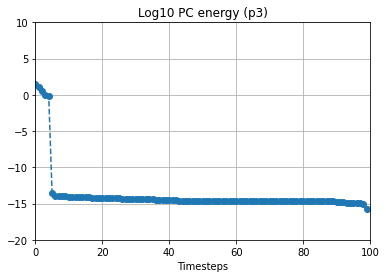

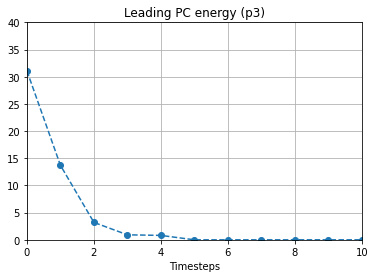

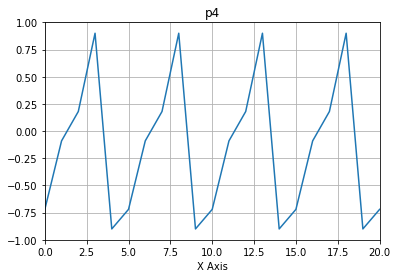

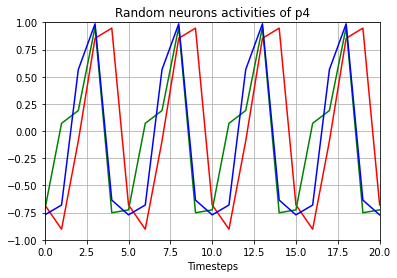

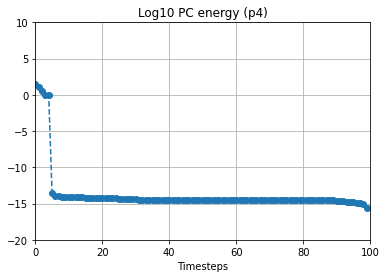

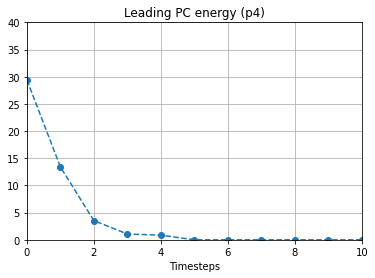

In [13]:
# Go through dataset
for i, data in enumerate(patterns_loader):
    # Inputs and labels
    inputs, outputs, labels = data

    # Show timeseries
    echotorch.utils.show_1d_timeseries(ts=inputs[0], title=u"p{}".format(i+1), xmin=0, xmax=20, ymin=-1, ymax=1, timesteps=21)

    # Compute hidden states
    hidden_states = esn(u=inputs.view(1, -1, 1).double(), y=inputs.view(1, -1, 1).double(), c=pattern_conceptors[i])

    # Save patterns
    patterns.append(inputs)

    # Show neurons activities
    echotorch.utils.neurons_activities_1d(
        stats=hidden_states[0],
        neurons=torch.LongTensor([0, 50, 99]),
        title=u"Random neurons activities of p{}".format(i+1),
        colors=['r', 'g', 'b'],
        xmin=0,
        xmax=20,
        ymin=-1,
        ymax=1,
        timesteps=21
    )

    # Show log10 PC energy
    echotorch.utils.plot_singular_values(stats=hidden_states[0], title=u"Log10 PC energy (p{})".format(i+1), log=True, xmin=0, xmax=100, ymin=-20, ymax=10)

    # Show leading PC energy
    S, U = echotorch.utils.plot_singular_values(stats=hidden_states[0], title=u"Leading PC energy (p{})".format(i+1), xmin=0, xmax=10, ymin=0, ymax=40)

    # Save SVD
    svd_matrices.append((S, U))

### Compute Similarities

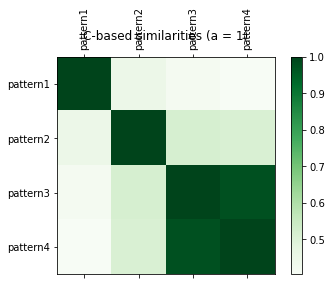

In [23]:
# Compute similarity matrix
sim_matrix = echotorch.utils.compute_similarity_matrix(svd_matrices)
#echotorch.utils.show_similarity_matrix(sim_matrix, u"R-based similarities")

# Close the conceptor net
esn.finalize()

# Close conceptors
for i in range(4):
    pattern_conceptors[i].finalize()
# end for

# Show similarities between conceptors
echotorch.utils.show_conceptors_similarity_matrix(pattern_conceptors, u"C-based similarities (a = {})".format(aperture))


## Plot Originals

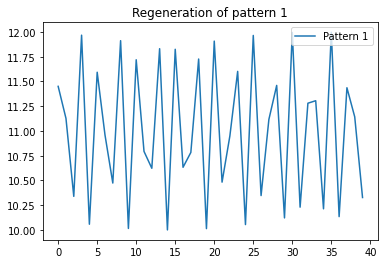

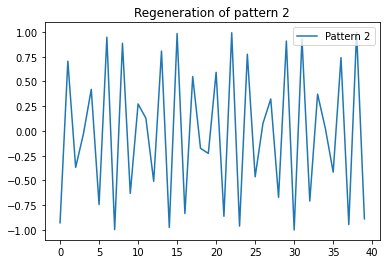

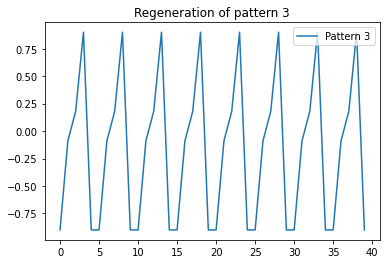

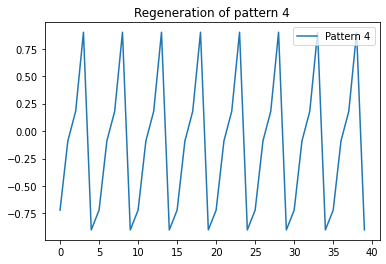

In [35]:
# For each patterns
for i, p in enumerate(patterns):
    # Plot original pattern
    plt.plot(p[0, washout_period:washout_period + 40].numpy())

    # Legends
    legends = list()
    legends.append(u"Pattern {}".format(i+1))

    # Aperture
    a = aperture
    # Regenerate pattern 1 for different aperture
    for j in range(5):
        # Generate timeseries
        y_hat = esn(c=pattern_conceptors[i],
                    reset_state=True,
                    length=washout_period + train_sample_length
        )
        # phase_shift, nrmse = echotorch.utils.find_phase_shift(y_hat[0, washout_period:], p[0, washout_period:].double(), interpolation_rate=500)

        # Plot
        #plt.plot(y_hat[0, washout_period+phase_shift:washout_period+phase_shift + 40].numpy())

        # Legend
        #legends.append(u"a = {} ({})".format(a, nrmse))

        # Multiply aperture
        #pattern_conceptors[i].multiply_aperture(factor)
        #a *= factor
    plt.legend(legends, loc='upper right')
    plt.title(u"Regeneration of pattern {}".format(i+1))
    plt.show()
    plt.close()